🧠 Classical Time Series Models
Great for small datasets or explainability.

1. ARIMA / SARIMA
Univariate

Good for individual customer time series

Doesn't handle multivariate inputs

2. Exponential Smoothing (Holt-Winters)
Good for capturing trends/seasonality

Works best on individual customer series

🧠 Machine Learning Models
Good if you extract features (lags, trends, rolling stats, etc.)

4. Random Forest / Gradient Boosting (e.g., XGBoost, LightGBM)
Treat it like a regression problem

Need feature engineering (lagged values, time of day/week, etc.)

Good for tabular-style learning

5. Linear Regression (with engineered features)
Works better than you'd think if features are well-designed

🧠 Deep Learning Models
Best when lots of data and long-term dependencies matter.

6. LSTM / GRU (Recurrent Neural Networks)
Sequence models, good for capturing temporal dependencies

Can be univariate or multivariate

PyTorch and TensorFlow support these

7. Temporal Convolutional Networks (TCN)
Alternative to RNNs

Often train faster and are easier to tune

8. Transformer-based Models
Powerful for long-range dependencies

Libraries: PyTorch Forecasting, HuggingFace Timeseries Transformers



PRAESENTATION SKETCH:

What data are we working with?
- Customer-level time series data
   - correlations? (show weekly autocorrelation plot and seasonal)
   - what different customers look like? (heating on weekends, at daytime, etc.)
   - outliers: 
        - increase in May 2024

What features do we use to train our models?
- Lagged values
- Temperature
- Fourier Features (bc very periodic data)
- photovoltaic data
- energy prices(?)
- ...

What models do we use and what performance do we get?

Conclusion


In [1]:
import pandas as pd
import jax.numpy as jnp
import jax
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from tristan_helpers import *  # Assuming the necessary helper functions are here
from utils import *

hyperparameters = {
    "seq_len": 24*7,
    "fut_seq_len": 1,
    "batch_size": 64,
    "learning_rate": 0.001,
    "num_epochs": 100,
}

In [2]:
Xs, ys, times = get_data('IT', [53], demand=[i for i in range(1, 24*365+1)], temp=[0], spv=[0], n_futures=1)
train_array = jnp.array(Xs)

/scratch/tzerweck/ETH/Datathon 2025/utils.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[col_name] = new_df[base_col].shift(lag)
/scratch/tzerweck/ETH/Datathon 2025/utils.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[col_name] = new_df[base_col].shift(lag)
/scratch/tzerweck/ETH/Datathon 2025/utils.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

In [3]:
print(f"Xs shape: {jnp.shape(Xs)}, ys shape: {jnp.shape(ys)}, times shape: {jnp.shape(times)}")
a = 24*365+1
print(Xs[0][0][a:])


/tmp/ipykernel_3258594/1105207430.py:1: DeprecationWarning: shape requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  print(f"Xs shape: {jnp.shape(Xs)}, ys shape: {jnp.shape(ys)}, times shape: {jnp.shape(times)}")


Xs shape: (1, 13869, 8767), ys shape: (1, 13869), times shape: (1, 13869)
[0.03375 0.03375 0.03375 1.      1.      1.     ]


In [ ]:
# ------------------------------
# 1. Load and prepare the data
# ------------------------------

# df = pd.read_csv("data/datasets2025/historical_metering_data_IT.csv", parse_dates=["DATETIME"])
# df = df.sort_values("DATETIME")

# Clean the dataset: drop rows with NaN values in the target column
# df = df.dropna(axis = 1, how = 'any')  # Drop rows with NaN in the target column
# target_col = "VALUEMWHMETERINGDATA_customerIT_53"  #try 53

# Normalize the target column. Split into train and test sets
scaler = MinMaxScaler(feature_range=(0, 1))
test_size = 31 * 24  # 30 days * 24 hours = 720 hours
# train_array = scaler.fit_transform(df[[target_col]].values[:-test_size])
# test_array = df[[target_col]].values[-test_size:]
# train_data = df[:-test_size]
# test_data = df[-test_size:]
train_array = train_array.squeeze()
train_array = scaler.fit_transform(train_array)
test_array = ys
# print(f"Train shape: {train_array.shape}, Test shape: {test_array.shape}")

# ------------------------------
# 2. Create Dataset Class
# ------------------------------

# Create DataLoader for training
seq_len = hyperparameters["seq_len"]
fut_seq_len = hyperparameters["fut_seq_len"]
train_dataset = TimeSeriesDataset(train_array, seq_len=seq_len, fut_seq_len=fut_seq_len)
train_loader = DataLoader(train_dataset, batch_size=hyperparameters["batch_size"], shuffle=True)

x,y = next(iter(train_loader))
print(f"X shape: {x.shape}, Y shape: {y.shape}")

# ------------------------------
# 3. Define LSTM Model
# ------------------------------

# Set device to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMForecast(fut_seq_len=fut_seq_len).to(device)
# model = TimeSeriesTransformer(seq_len=seq_len).to(device)  # Use the transformer model
# model = TCNForecast(input_dim=1).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# ------------------------------
# 4. Training Loop
# ------------------------------

# Training loop with progress bar
progress_bar = tqdm(range(hyperparameters["num_epochs"]), desc="Training Epochs")
epoch_losses = []
for epoch in progress_bar:
    model.train()
    total_loss = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)  # Move data to GPU
        print(f"X shape: {x.shape}, Y shape: {y.shape}")
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    progress_bar.set_postfix(loss=f"{avg_loss:.5f}")

# Save the trained model
model_path = "saved_models/lstm_forecast.pt"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# ------------------------------
# 5. Plot the Loss
# ------------------------------

plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label="Training Loss", color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


X shape: torch.Size([64, 168, 8767]), Y shape: torch.Size([64, 1, 8767])


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]/scratch/tzerweck/ETH/Datathon 2025/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 1, 8767])) that is different to the input size (torch.Size([64, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/scratch/tzerweck/ETH/Datathon 2025/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([5, 1, 8767])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training Epochs:   2%|▏         | 2/100 [00:51<42:09, 25.81s/it, loss=0.07908]


KeyboardInterrupt: 

Total predictions to evaluate: 743 (does include skipped indices because of zero actual values)
[0.07544446331262589, 0.15031393410265445, 0.021426084212958812, 0.1223312271013856, 0.03402515917271376, 0.027764065727591516, 0.1155785544142127, 0.3501910760700703, 0.3749014230966568, 0.372665344029665, 0.3257306886613369, 0.419222524613142, 0.4758534033894539, 0.4188945827186108, 0.4587827040553093, 0.4435599871873856, 0.452604116499424, 0.4181213251948357, 0.4644953728616238, 0.4180620245039463, 0.4076739419102669, 0.3055408583879471, 0.03921614469587803, 0.01796361241489649, 0.015680242247879506, 0.02739442386478186, 0.015470875047147274, 0.009892900474369526, 0.03389884496480226, 0.041759135529398916, 0.166186850219965, 0.38622641390562057, 0.3297014864087105, 0.39900392469763757, 0.47284054398536685, 0.5489075311124325, 0.5019646558463574, 0.4591540406048298, 0.45638142639398577, 0.42141035181283953, 0.4504236551821232, 0.44007101422548295, 0.40971856141090396, 0.38591154912114145, 

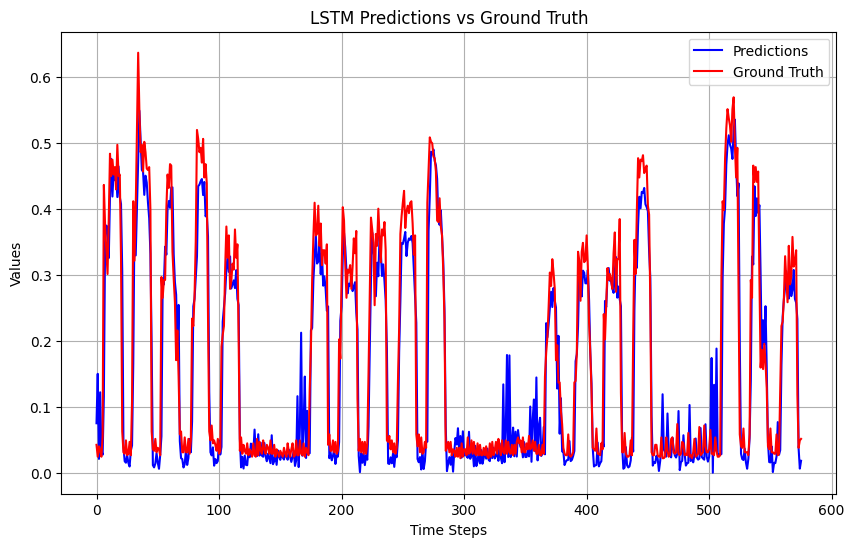

In [24]:
# ------------------------------
# 6. Evaluation
# ------------------------------

model_path = "saved_models/lstm_forecast.pt"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Switch model to evaluation mode
model.eval()

rel_error = []
total_predictions = len(test_array) - fut_seq_len
print(f"Total predictions to evaluate: {total_predictions} (does include skipped indices because of zero actual values)")
skipped_indices = 0
not_skipped_indices = 0
predictions = []
actual_values = []

for idx in range(seq_len, len(test_array)- fut_seq_len + 1):  # Start from seq_len because we need previous data for prediction
    last_seq = torch.tensor(test_array[idx- seq_len:idx], dtype=torch.float32).to(device)
    actual_value = test_array[idx: idx + fut_seq_len]
    actual_values.append(actual_value)
    # Handle division by zero
    # if actual_value != 0:
    with torch.no_grad():
        pred = model(last_seq.unsqueeze(0))  # Make the prediction
        
        # Move tensor to CPU and reshape for inverse scaling
        pred_rescaled = scaler.inverse_transform(pred.cpu().unsqueeze(0).reshape(-1, 1))
        predictions.append(pred_rescaled[0][0])

    rel_error.append(abs((pred_rescaled[0][0] - actual_value)/ actual_value))
    not_skipped_indices += 1
    
    # else:
    #     skipped_indices += 1
    #     continue

accuracy = jnp.mean(jnp.array(rel_error))
# print(rel_error)
# print(f"Model accuracy: {accuracy:.2f}%")
# print(f"Percentage of skipped indices due to zero actual value: {skipped_indices/(skipped_indices + not_skipped_indices)*100:.2f}%")

predictions = [float(val) for val in predictions]

print(predictions)
print(len(predictions))
# plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(predictions, label="Predictions", color='blue')
plt.plot(jnp.asarray(actual_values).flatten(), label="Ground Truth", color='red')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('LSTM Predictions vs Ground Truth')
plt.legend()
plt.grid(True)
plt.show()